In [1]:
from ultralytics import YOLO
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
import torchvision.transforms as T
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import copy

In [2]:
class ShoppingCartDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        image = Image.open(img_path).convert('RGB')
        original_size = image.size
        if self.transform:
            image = self.transform(image)

        # Load label
        with open(label_path, 'r') as file:
            label = file.readline().strip().split()
        label = torch.tensor([float(x) for x in label], dtype=torch.float32)

        return image, label, original_size

In [3]:
def bbox_visualization(img_tensor, edgecolor=None, labels_ground=None, labels_xyxy=None, transforms=None):
    if labels_ground != None:
        _, cx, cy, w, h = labels_ground
        transformed_size = img_tensor.shape[-2:]
        x1 = (cx - w / 2) * transformed_size[0]
        y1 = (cy - h / 2) * transformed_size[1]
        x2 = (cx + w / 2) * transformed_size[0]
        y2 = (cy + h / 2) * transformed_size[1]
    else:
        x1, y1, x2, y2 = labels_xyxy

    fig, ax = plt.subplots(1)
    ax.imshow(img_tensor.permute(1, 2, 0))
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=edgecolor if edgecolor else 'r', facecolor='none')
    ax.add_patch(rect)
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def get_transforms(resize, target_size, mean_rgb, std_rgb, tf=None):
    return {
    "train": transforms.Compose([
        transforms.Resize(resize),
        # transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        # tf,
        # transforms.Normalize(mean_rgb, std_rgb)
    ]),

    "test": transforms.Compose([
        transforms.Resize(target_size),
        # transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        # tf,
        # transforms.Normalize(mean_rgb, std_rgb)
    ])
}

## Augumentation

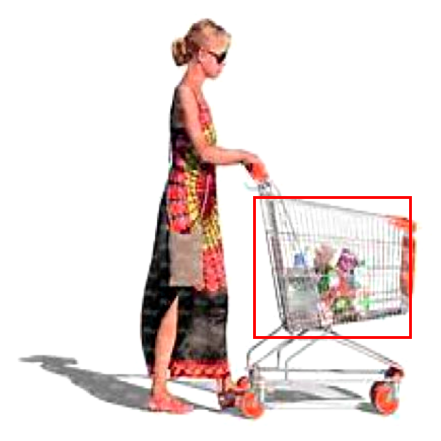

In [4]:
# Perform Augumentations
resize = (640, 640)
target_size = (640, 640) # TODO: Change here
# will calculate the mean and standard deviation of the images from the whole training set.
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
transform = get_transforms(resize, target_size, mean_rgb, std_rgb)

train_dataset = ShoppingCartDataset(
    "dataset/ShoppingCart.v1i.yolov8/train/images",
    "dataset/ShoppingCart.v1i.yolov8/train/labels",
    transform=transform["train"]
)
test_dataset = ShoppingCartDataset(
    "dataset/ShoppingCart.v1i.yolov8/test/images",
    "dataset/ShoppingCart.v1i.yolov8/test/labels",
    transform=transform["test"]
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

img, label, original_size = train_dataset[63]  # Index 0 for example # TODO: Problem: The BBox can only plot one Cart! Modify visualization fuction below to change the behavior

# Show image with bounding box
bbox_visualization(img, edgecolor='r', labels_ground=label, transforms=transform["train"])

## Transfer Learning

In [5]:
model = YOLO("yolov8s.pt").cuda()

# old_dict = copy.deepcopy(model.state_dict())
# model.head = torch.nn.Identity()

<bound method Module.parameters of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum

### output layer control

In [7]:
num_classes = 1  # "shopping cart"
output_channels = (5 + num_classes)  # cart class + bbox + class score
in_channels = model.model.model[22].cv3[-1][2].in_channels # 至于怎么找到的, 应该是自己摸索出来的吧
model.model.model[22].cv3[-1][2] = nn.Conv2d(in_channels, output_channels, kernel_size=(1, 1), stride=(1, 1))
nn.init.xavier_uniform_(model.model.model[22].cv3[-1][2].weight)
nn.init.zeros_(model.model.model[22].cv3[-1][2].bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)

In [8]:
model.model.model[22].cv3[-1]

<bound method Module.parameters of Sequential(
  (0): Conv(
    (conv): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): Conv2d(128, 6, kernel_size=(1, 1), stride=(1, 1))
)>

## Fine-Tuning

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss().cuda()

for epoch in range(10):
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} with Train MSE Loss: {running_loss/len(train_loader)}")


RuntimeError: shape '[1, 144, -1]' is invalid for input of size 28000